In [1]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
df = pd.read_csv(r"gva_mass_shootings-2025-10-21.csv")
df

,incident_id,incident_date,incident_time,updated_date,state,city_or_county,address,business_location_name,latitude,longitude,...,injured,victims_killed,victims_injured,suspects_killed,suspects_injured,suspects_arrested,incident_characteristics,sources,date_fixed,year
0,809048,"April 1, 2017",NaN,1491348530,Florida,Tampa,219 S Howard Ave,Palace Lounge,27.9431,-82.4831,...,4,1,4,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://wfla.com/2017/04/01/tampa-police-inv...",2017-04-01,2017
1,809499,"April 1, 2017",5:25 AM,1680156402,Oklahoma,Oklahoma City,1212 N Woodward Ave,NaN,35.4810,-97.5754,...,3,2,3,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://www.news9.com/story/35055747/okc-pol...",2017-04-01,2017
2,809815,"April 1, 2017",NaN,1492995601,California,Pittsburg,100 block of Madoline Street,NaN,38.0053,-121.8950,...,5,0,5,0,0,1,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",http://www.nbcbayarea.com/news/local/Shooting-...,2017-04-01,2017
3,1082835,"April 1, 2018",2:15 AM,1522693801,Michigan,Saginaw,600 block of Yale St,NaN,43.4192,-83.9819,...,5,0,5,0,0,0,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",http://www.mlive.com/news/saginaw/index.ssf/20...,2018-04-01,2018
4,1083011,"April 1, 2018",NaN,1646889853,Alabama,Mobile,3556 Halls Mill Rd,Grand Hall,30.6387,-88.1228,...,4,1,4,0,0,3,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://www.al.com/news/mobile/index.ssf/201...",2018-04-01,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5463,2411007,"September 9, 2022",4:50 PM,1722738993,New York,Bronx,810 Astor Ave,Pelham Parkway Houses,40.8592,-73.8634,...,4,0,4,0,0,1,"Shot - Wounded/Injured, Mass Shooting (4+ vict...","c(""https://twitter.com/NYC_Alerts911/status/15...",2022-09-09,2022
5464,2411901,"September 9, 2022",11:50 PM,1689272621,Minnesota,Minneapolis,328 W Broadway Ave,4th Street Saloon,44.9994,-93.2848,...,3,1,3,0,0,0,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""https://www.fox9.com/news/2-pregnant-women-...",2022-09-09,2022
5465,2410446,"September 9, 2022",9:00 AM,1715920831,Maryland,Elk Mills,47 Hebron Ct,NaN,39.6611,-75.8365,...,0,4,0,1,0,0,"Shot - Dead (murder, accidental, or suicide), ...","c(""https://www.cbsnews.com/baltimore/news/five...",2022-09-09,2022
5466,2703975,"September 9, 2023",11:30 PM,1694472936,South Carolina,Rock Hill,800 block of Brunswick Dr,NaN,34.8921,-81.0411,...,4,0,4,0,0,2,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",https://www.heraldonline.com/news/local/crime/...,2023-09-09,2023


In [2]:
#### Add the prevalence percent of depression for each state in the US

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

In [4]:
## Read in the URL and scrape using BeautifulSoup 
url = "https://www.cdc.gov/mmwr/volumes/72/wr/mm7224a1.htm"

response = requests.get(url)


In [5]:
response

<Response [200]>

In [6]:
soup=BeautifulSoup(response.content)


In [7]:
## Data cleaning of data resulting from the scraping

In [8]:
table=soup.find_all(attrs={"class":"table table-bordered table-responsive"})

In [9]:
def get_country_percent(table):
    check=[]
    for tr in table[1].select("tbody"):
        for td in tr:
            m=td.get_text().strip().replace("\n","").replace(",","")
            check.append(m)
    return check[1::2]

In [10]:
country_raw=get_country_percent(table)

In [11]:
data_pattern = re.compile(
    r"""
    ^
    ([A-Za-z\s]+)         # Group 1: State Name (Letters and spaces from the start)
    (\d+)                  # Group 2: Count 1 (A sequence of digits)
    (\d+)                  # Group 3: Count 2 (A sequence of digits)
    (\d+)                  # Group 4: Count 3 (A sequence of digits)
    
    # Group 5: Rate 1 (e.g., '23.5 (22.1–25.0)')
    (
        [\d\.]+               # Match the main number (e.g., 23.5)
        \s?                   # Optional space (in case your data sometimes has a space)
        \(                    # Literal opening parenthesis
        [\d\.\,\–\-]+         # Match digits, dots, commas, en-dashes, or hyphens inside the parens
        \)                    # Literal closing parenthesis
    )
    
    # Group 6: Rate 2 (Identical format to Rate 1)
    (
        [\d\.]+
        \s?
        \(
        [\d\.\,\–\-]+
        \)
    )
    $
    """, re.VERBOSE # re.VERBOSE allows us to add comments and spacing for readability
)

In [12]:
def get_clean_data(word):
    structured=[]
    for item in word:
        match=data_pattern.match(item)
        structured.append(list(match.groups()))
    a=[]
    for i in structured:
        index=[0,2,3,4]
        for k in index:
            t=i[k]
            a.append(t)
    return a  

In [13]:
country_clean=get_clean_data(country_raw)

In [14]:
def merge_state_and_rate(flattened_list):
    """
    Merges the State Name (index i) with the constructed Rate 
    (indices i+1, i+2, and the first part of i+3) 
    for every four-item block in the list.
    """
    merged_results = []
    
    # Iterate through the list, starting at index 0 and stepping by 4
    for i in range(0, len(flattened_list), 4):
        
        # 1. State Name is at the current index 'i'
        state_name = flattened_list[i]
        
        # 2. Rate components are at i+1, i+2, and i+3.
        # We must strip the parenthetical part from the last element (i+3).
        rate_part1 = flattened_list[i + 1] # e.g., '2'
        rate_part2 = flattened_list[i + 2] # e.g., '3'
        rate_fragment = flattened_list[i + 3].split(' ')[0] # e.g., '.5' from '.5 (22.1–25.0)'
        
        # 3. Concatenate to form the final rate string
        merged_rate = f"{rate_part1}{rate_part2}{rate_fragment}" # e.g., '23.5'
        
        # 4. Combine the state and the rate into the desired format
        final_string = f"{state_name}, {merged_rate}"
        
        merged_results.append(final_string)
            
    return merged_results

In [15]:
# Percentage column formatted to numeric
def final_clean(table):
    data2=merge_state_and_rate(country_clean)
    processed_data = [item.split(', ') for item in data2]
    df = pd.DataFrame(processed_data, columns=["state", "prevalence_percent"])
    df["prevalence_percent"]=pd.to_numeric(df["prevalence_percent"])
    return df

In [16]:
final_country_perc=final_clean(country_clean)

In [17]:
final_country_perc

,state,prevalence_percent
0,Alabama,23.5
1,Alaska,15.9
2,Arizona,17.4
3,Arkansas,23.5
4,California,14.1
5,Colorado,18.5
6,Connecticut,17.7
7,Delaware,15.6
8,District of Columbia,19.8
9,Florida,14.7


C:\Users\HP\AppData\Local\Temp\ipykernel_9844\1042794757.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


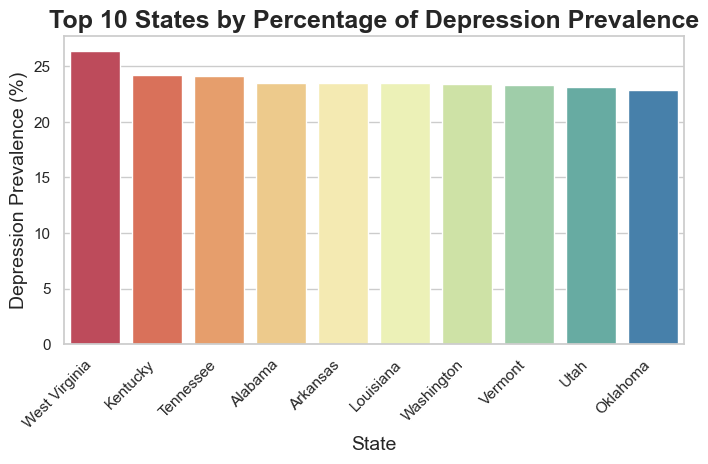

In [18]:
country_sorted = final_country_perc.sort_values(by='prevalence_percent', ascending=False)
data_chart = pd.DataFrame(country_sorted)
df_top_10 = data_chart.head(10)
#Setup Visualization Style ---
sns.set_theme(style="whitegrid")

#Create the Bar Chart using the Filtered Data ---
plt.figure(figsize=(8,4))

# Plot only the df_top_10 DataFrame
bar_plot = sns.barplot(
    x='state',
    y='prevalence_percent',
    data=df_top_10, # <-- Using the filtered DataFrame
    palette='Spectral'
)

#Enhance the Plot ---
plt.title('Top 10 States by Percentage of Depression Prevalence', fontsize=18, fontweight='bold')
plt.xlabel('State', fontsize=14)
plt.ylabel('Depression Prevalence (%)', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()

In [19]:
## Merge the table of depression percent per year with the main df table 
df_depressed=pd.merge(df,final_country_perc,on="state")

In [20]:
df_depressed

,incident_id,incident_date,incident_time,updated_date,state,city_or_county,address,business_location_name,latitude,longitude,...,victims_killed,victims_injured,suspects_killed,suspects_injured,suspects_arrested,incident_characteristics,sources,date_fixed,year,prevalence_percent
0,809048,"April 1, 2017",NaN,1491348530,Florida,Tampa,219 S Howard Ave,Palace Lounge,27.9431,-82.4831,...,1,4,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://wfla.com/2017/04/01/tampa-police-inv...",2017-04-01,2017,14.7
1,809499,"April 1, 2017",5:25 AM,1680156402,Oklahoma,Oklahoma City,1212 N Woodward Ave,NaN,35.4810,-97.5754,...,2,3,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://www.news9.com/story/35055747/okc-pol...",2017-04-01,2017,22.9
2,809815,"April 1, 2017",NaN,1492995601,California,Pittsburg,100 block of Madoline Street,NaN,38.0053,-121.8950,...,0,5,0,0,1,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",http://www.nbcbayarea.com/news/local/Shooting-...,2017-04-01,2017,14.1
3,1082835,"April 1, 2018",2:15 AM,1522693801,Michigan,Saginaw,600 block of Yale St,NaN,43.4192,-83.9819,...,0,5,0,0,0,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",http://www.mlive.com/news/saginaw/index.ssf/20...,2018-04-01,2018,19.5
4,1083011,"April 1, 2018",NaN,1646889853,Alabama,Mobile,3556 Halls Mill Rd,Grand Hall,30.6387,-88.1228,...,1,4,0,0,3,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://www.al.com/news/mobile/index.ssf/201...",2018-04-01,2018,23.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5463,2411007,"September 9, 2022",4:50 PM,1722738993,New York,Bronx,810 Astor Ave,Pelham Parkway Houses,40.8592,-73.8634,...,0,4,0,0,1,"Shot - Wounded/Injured, Mass Shooting (4+ vict...","c(""https://twitter.com/NYC_Alerts911/status/15...",2022-09-09,2022,16.8
5464,2411901,"September 9, 2022",11:50 PM,1689272621,Minnesota,Minneapolis,328 W Broadway Ave,4th Street Saloon,44.9994,-93.2848,...,1,3,0,0,0,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""https://www.fox9.com/news/2-pregnant-women-...",2022-09-09,2022,19.8
5465,2410446,"September 9, 2022",9:00 AM,1715920831,Maryland,Elk Mills,47 Hebron Ct,NaN,39.6611,-75.8365,...,4,0,1,0,0,"Shot - Dead (murder, accidental, or suicide), ...","c(""https://www.cbsnews.com/baltimore/news/five...",2022-09-09,2022,15.7
5466,2703975,"September 9, 2023",11:30 PM,1694472936,South Carolina,Rock Hill,800 block of Brunswick Dr,NaN,34.8921,-81.0411,...,0,4,0,0,2,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",https://www.heraldonline.com/news/local/crime/...,2023-09-09,2023,21.4


In [21]:
incident_count = df_depressed.groupby("state").agg({"incident_id":"count","prevalence_percent":"mean"})
incident_count

,incident_id,prevalence_percent
state,,
Alabama,145,23.5
Alaska,6,15.9
Arizona,61,17.4
Arkansas,62,23.5
California,471,14.1
Colorado,87,18.5
Connecticut,35,17.7
Delaware,21,15.6
District of Columbia,90,19.8


In [22]:
cor_check=incident_count.sort_values(by="incident_id", ascending=False)
cor_check.rename(columns={"incident_id":"incident_count"}, inplace=True)

#Comparing the top 10 states with highest depression percentage $ top 10 states with highest gun incidents, 
#only Tennessee appears on both list, prompting a correlation relationship check.

C:\Users\HP\AppData\Local\Temp\ipykernel_9844\1723849659.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


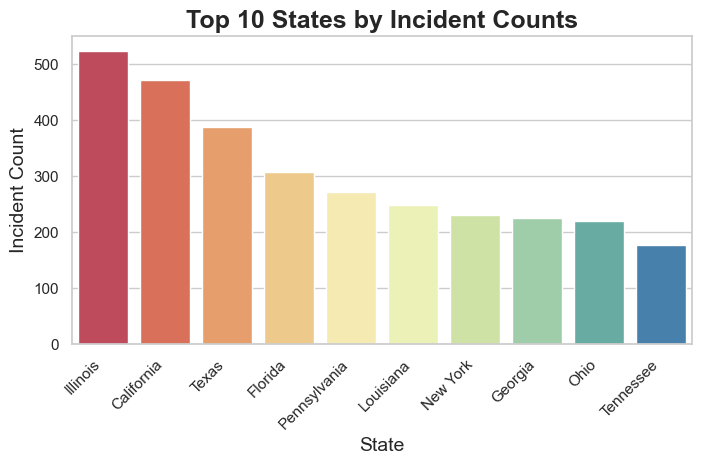

In [23]:
incident_sorted = cor_check.sort_values(by="incident_count", ascending=False)
data_chart2 = pd.DataFrame(incident_sorted)
df_top_10 = data_chart2.head(10)
#Setup Visualization Style ---
sns.set_theme(style="whitegrid")

#Create the Bar Chart using the Filtered Data ---
plt.figure(figsize=(8,4))

# Plot only the df_top_10 DataFrame
bar_plot = sns.barplot(
    x='state',
    y='incident_count',
    data=df_top_10, # <-- Using the filtered DataFrame
    palette='Spectral'
)

#Enhance the Plot ---
plt.title('Top 10 States by Incident Counts', fontsize=18, fontweight='bold')
plt.xlabel('State', fontsize=14)
plt.ylabel('Incident Count', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()

In [24]:
r_coeff, p_value = pearsonr(cor_check['incident_count'], cor_check['prevalence_percent'])
print("--- Analysis of Weak Correlation ---")
print(f"Pearson r: {r_coeff:.4f}")
print(f"P-value: {p_value:.4f}")

--- Analysis of Weak Correlation ---
Pearson r: -0.2423
P-value: 0.0867


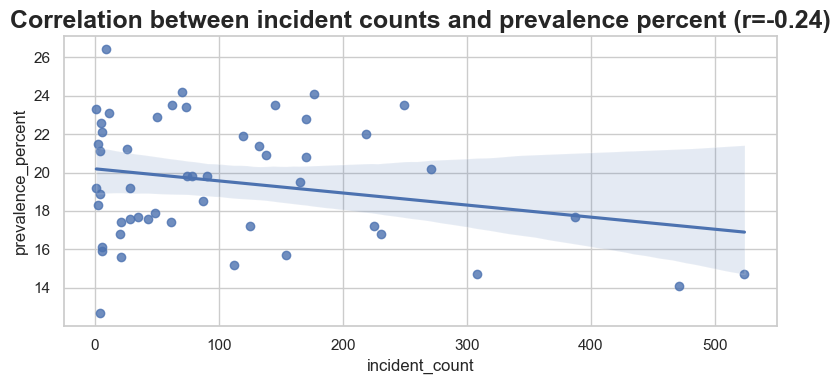

In [25]:
## Corellation plot for incident counts and depression percentage
plt.figure(figsize=(8, 4))
sns.regplot(x='incident_count', y='prevalence_percent', data=cor_check)
plt.title(f'Correlation between incident counts and prevalence percent (r={cor_check['incident_count'].corr(cor_check['prevalence_percent']):.2f})', fontsize=18, fontweight='bold')

plt.tight_layout()
plt.show()

# Hypothesis
H0: There is no linear relationship between incident counts and depression prevalence r=0 <p>
H1: There is a linear relationship between incident counts and depression prevalence r!=0 <p>
Since P-value>0.05, there is no statistical significance in the correlation.
We accept the alternative hypothesis.
This implies that the number of incidents increases as the depression prevalence in percentage reduces for all states.